In [1]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=4, threads_per_worker=1,  memory_limit='6GB')
client = Client(cluster)

In [2]:
from tropical_cyclones import TCs, multi_plot, plot_trajectories
from aqua.core.util import load_yaml

config = load_yaml('config_tcs_notebook.yaml')

/work/users/mccorda/miniforge3/envs/aqua-diagnostics/lib/python3.12/site-packages/intake_esm/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [3]:
# initialise tropical class with streaming options
tropical = TCs(tdict=config, streaming=True,
                stream_step=config['stream']['streamstep'],
                stream_startdate=config['time']['startdate'],
                paths=config['paths'],
                loglevel=config['setup']['loglevel'],
                orography=True,
                nproc=1)

2026-01-14 14:06:08 :: TCs :: WARNING  -> Model ERA5 - Exp: era5
2026-01-14 14:06:08 :: TCs :: WARNING  -> Initialised streaming for 1D days starting on 1979-01-01 00:00:00


In [4]:
# ===========================================
# 1. SETUP - Parametri da config
# ===========================================
import os
from glob import glob
from datetime import datetime

trackdir = config['paths']['trackdir']
tmpdir = config['paths']['tmpdir']
era5_dir = "/work/users/mccorda/data"
start_date = datetime.strptime(config['time']['startdate'], "%Y%m%d")
end_date   = datetime.strptime(config['time']['enddate'], "%Y%m%d")

In [6]:
# ===========================================
# 2. SELEZIONE FILE - Trova i file tempest_track nel range di date
# ===========================================
all_files = sorted(glob(os.path.join(trackdir, "tempest_track_*.txt")))
filenames = []
for f in all_files:
    base = os.path.basename(f)
    try:
        parts = base.replace("tempest_track_", "").replace(".txt", "").split("-")
        start_f = datetime.strptime(parts[0], "%Y%m%d")
        end_f = datetime.strptime(parts[1], "%Y%m%d")
        if end_f >= start_date and start_f <= end_date:
            filenames.append(f)
    except:
        pass

print(f"[INFO] File selezionati: {len(filenames)}")

[INFO] File selezionati: 783


In [7]:
# ===========================================
# 3. MERGE FILE - CON STORM_ID UNICI
# ===========================================
os.makedirs(tmpdir, exist_ok=True)
tot_file = os.path.join(tmpdir, f"tempest_tracks_tot_{config['time']['startdate']}_{config['time']['enddate']}.txt")

global_storm_id = 0  # Contatore globale

with open(tot_file, 'w') as output_file:
    output_file.write("track_id year month day hour i j lon lat slp wind zs\n")
    
    for fname in filenames:
        with open(fname, 'r') as infile:
            lines = infile.readlines()
            
            if len(lines) == 0:
                print(f"[WARNING] File vuoto: {fname}")
                continue
            
            # Mappa storm_id locali -> storm_id globali
            local_to_global = {}
            
            for line in lines[1:]:  # Skippa header
                clean = line.replace(',', '').strip()
                if not clean:
                    continue
                parts = clean.split()
                if len(parts) != 12:
                    continue
                
                local_id = parts[0]
                
                # Assegna nuovo ID globale se è la prima volta che vediamo questo local_id
                if local_id not in local_to_global:
                    local_to_global[local_id] = str(global_storm_id)
                    global_storm_id += 1
                
                # Sostituisci con ID globale
                parts[0] = local_to_global[local_id]
                output_file.write(" ".join(parts) + "\n")

print(f"[INFO] File totale creato: {tot_file}")
print(f"[INFO] Totale storm unici: {global_storm_id}")

[WARNING] File vuoto: /work/users/mccorda/tc_analysis/trackdir/ERA5/era5/tempest_track_19840430-19840529.txt
[WARNING] File vuoto: /work/users/mccorda/tc_analysis/trackdir/ERA5/era5/tempest_track_19880430-19880529.txt
[WARNING] File vuoto: /work/users/mccorda/tc_analysis/trackdir/ERA5/era5/tempest_track_20050501-20050530.txt
[INFO] File totale creato: /work/users/mccorda/tc_analysis/tmpdir/ERA5/era5/tempest_tracks_tot_19790101_20150106.txt
[INFO] Totale storm unici: 2373


In [8]:
# ===========================================
# 4. FILTRO STJ - Applica il filtro 
# ===========================================
import sys
import os

# ============================================================
#   STJ Filter (versione adattata ai dati 250 hPa)
#   Basato sul metodo di Bourdin et al. (2022)
#   Versione semplificata: climatologia mensile, soglie su U e V,
#   jet-lat trovato come massimo del profilo del wind speed.
#   FIX: gestisce sia spazi che virgole come separatori
# ============================================================

# Path TCs_filter.py
custom_path = '/home/mccorda/work/AQUA-diagnostics/frontier-diagnostics/tropical_cyclones/tropical_cyclones/tools/'
if custom_path not in sys.path:
    sys.path.insert(0, custom_path)

# Import the filter
from TCs_filter import filter_STJ_Bourdin250_monthly

# Apply the filter to tot_file
filtered_file, jet_lat_NH, jet_lat_SH = filter_STJ_Bourdin250_monthly(
    trajfile=tot_file,
    era5_dir=era5_dir,
    buffer_deg=8.0,  # buffer zone in gradi
    lat_min=10,      # limite equatoriale per jet search
    lat_max=50       # limite polare per jet search
)

print(f"\n✓ File filtrato creato: {filtered_file}")

[INFO] STJ filter (Bourdin 250 hPa monthly) applied to /work/users/mccorda/tc_analysis/tmpdir/ERA5/era5/tempest_tracks_tot_19790101_20150106.txt

STJ FILTER - Bourdin et al. (2022) method
Input file: /work/users/mccorda/tc_analysis/tmpdir/ERA5/era5/tempest_tracks_tot_19790101_20150106.txt
Buffer zone: 8.0° equatorward of jet
Jet detection: U>=25 m/s, V>=25 m/s
Data period: 1979–2014 (35 years)

Computing ERA5 250 hPa monthly climatology...
  Loading 1979 ERA5 250 hPa...


  Loading 1980 ERA5 250 hPa...
  Loading 1981 ERA5 250 hPa...
  Loading 1982 ERA5 250 hPa...
  Loading 1983 ERA5 250 hPa...
  Loading 1984 ERA5 250 hPa...
  Loading 1986 ERA5 250 hPa...
  Loading 1987 ERA5 250 hPa...
  Loading 1988 ERA5 250 hPa...
  Loading 1989 ERA5 250 hPa...
  Loading 1990 ERA5 250 hPa...
  Loading 1991 ERA5 250 hPa...
  Loading 1992 ERA5 250 hPa...
  Loading 1993 ERA5 250 hPa...
  Loading 1994 ERA5 250 hPa...
  Loading 1995 ERA5 250 hPa...
  Loading 1996 ERA5 250 hPa...
  Loading 1997 ERA5 250 hPa...
  Loading 1998 ERA5 250 hPa...
  Loading 1999 ERA5 250 hPa...
  Loading 2000 ERA5 250 hPa...
  Loading 2001 ERA5 250 hPa...
  Loading 2002 ERA5 250 hPa...
  Loading 2003 ERA5 250 hPa...
  Loading 2004 ERA5 250 hPa...
  Loading 2005 ERA5 250 hPa...
  Loading 2006 ERA5 250 hPa...
  Loading 2007 ERA5 250 hPa...
  Loading 2008 ERA5 250 hPa...
  Loading 2009 ERA5 250 hPa...
  Loading 2010 ERA5 250 hPa...
  Loading 2011 ERA5 250 hPa...
  Loading 2012 ERA5 250 hPa...
  Loadin

In [9]:
# ===========================================
# 5: load data (memory)
# ===========================================
import sys
import os

tools_path = '/home/mccorda/work/AQUA-diagnostics/frontier-diagnostics/tropical_cyclones/tropical_cyclones/tools/'
plots_path = '/home/mccorda/work/AQUA-diagnostics/frontier-diagnostics/tropical_cyclones/tropical_cyclones/plots/'

if tools_path not in sys.path:
    sys.path.insert(0, tools_path)
if plots_path not in sys.path:
    sys.path.insert(0, plots_path)

from tc_data_manager import TCDataManager
from plotting_TCs_custom_memory import * # import all the plotting functions created there

# CARICA DATI UNA VOLTA SOLA
tc_data = TCDataManager(filtered_file)
tc_data.summary()



LOADING TC DATA INTO MEMORY
Source: /work/users/mccorda/tc_analysis/tmpdir/ERA5/era5/tempest_tracks_tot_19790101_20150106_filtered_STJ_Bourdin250_monthly.txt
  Parsed 54,514 observations from file
  Converting to numpy arrays...
  Building trajectory dictionary...
✓ Data loaded successfully!
  Observations: 54,514
  Storms: 2349


TC DATA SUMMARY
Source file: /work/users/mccorda/tc_analysis/tmpdir/ERA5/era5/tempest_tracks_tot_19790101_20150106_filtered_STJ_Bourdin250_monthly.txt
Total observations: 54,514
Total storms: 2349

Time period:
  Start: 1979-01
  End: 2014-12
  Duration: 432 months

Data ranges:
  SLP: 92693.3 - 101968.6 Pa
  Wind: 2.2 - 33.6 m/s
  Latitude: -67.5° to 66.5°
  Longitude: 0.0° to 359.0°

Memory usage:
  Total: 5.41 MB



✓ Using data from memory (fast!)
✓ Plot saved to: /work/users/mccorda/tc_analysis/Figures/tracks_ERA5_era5_19790101_20150106.pdf


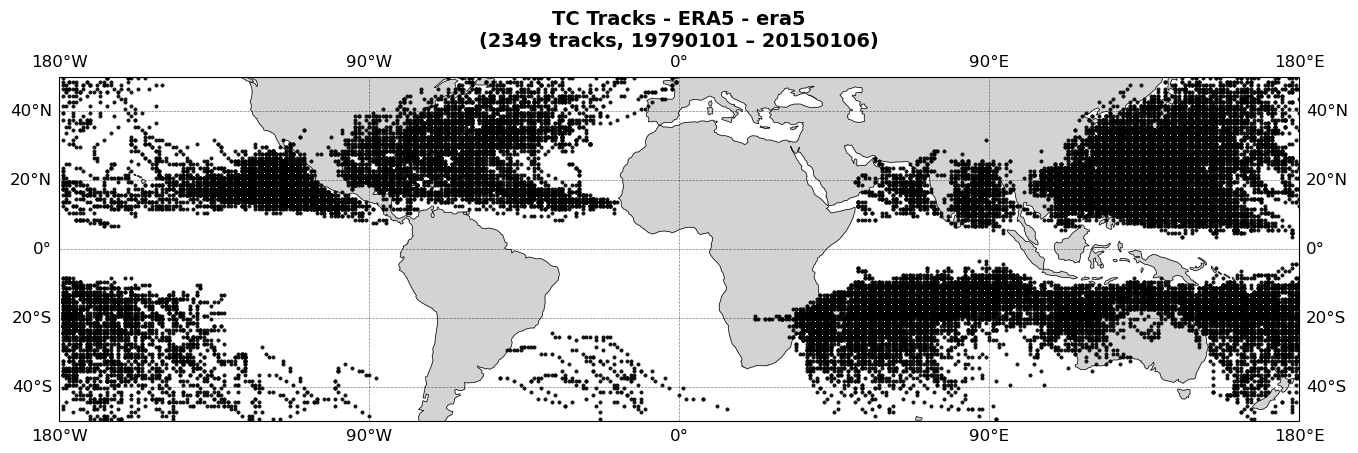

✓ Using data from memory (fast!)
✓ Plot saved to: /work/users/mccorda/tc_analysis/Figures/tracks_colored_category_ERA5_era5_19790101_20150106.pdf


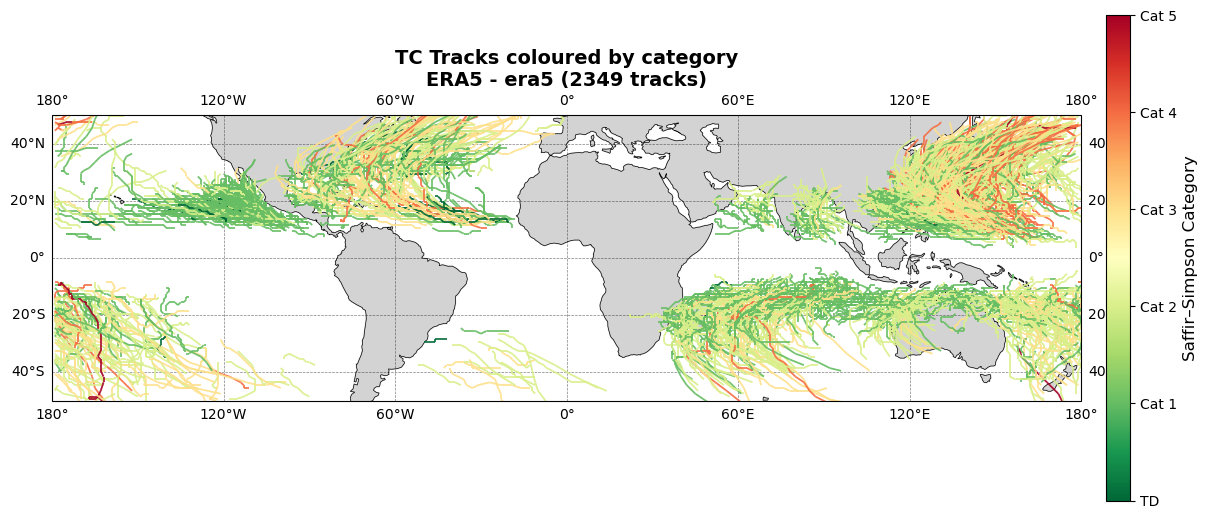

✓ Using data from memory (fast!)
✓ Found 98 trajectories for Cat 4 (945–959)


/work/users/mccorda/miniforge3/envs/aqua-diagnostics/lib/python3.12/site-packages/shapely/creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)
/work/users/mccorda/miniforge3/envs/aqua-diagnostics/lib/python3.12/site-packages/shapely/creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)
/work/users/mccorda/miniforge3/envs/aqua-diagnostics/lib/python3.12/site-packages/shapely/creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)
/work/users/mccorda/miniforge3/envs/aqua-diagnostics/lib/python3.12/site-packages/shapely/creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)
/work/users/mccorda/miniforge3/envs/aqua-diagnostics

✓ Plot saved: /work/users/mccorda/tc_analysis/Figures/tracks_cat4_ERA5_era5_19790101_20150106.pdf


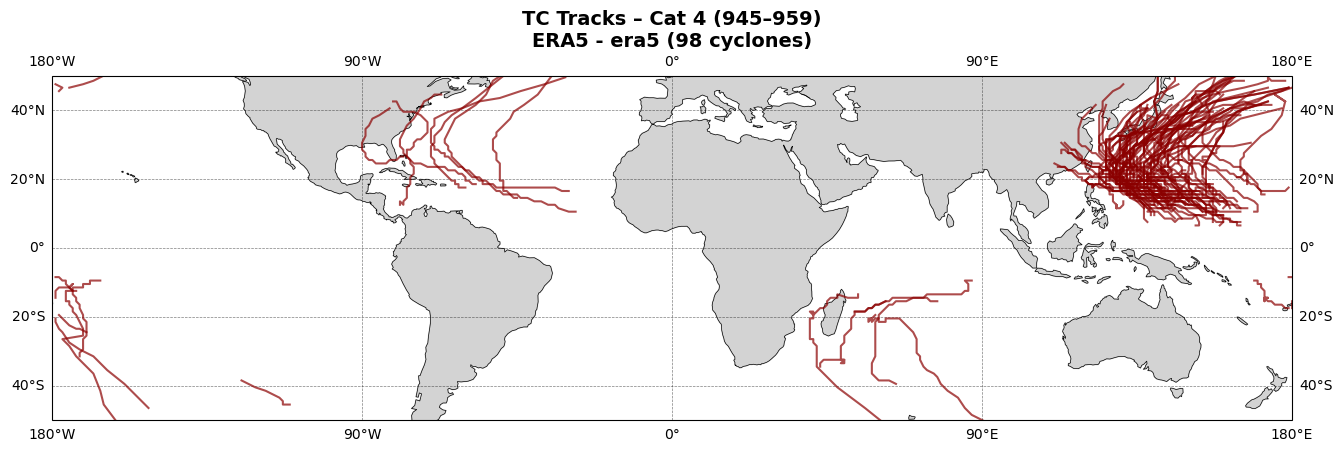

✓ Using data from memory (fast!)
Total TC observation points: 54,514
Sampling 50,000 points for KDE...
Computing KDE...
✓ Plot saved: /work/users/mccorda/tc_analysis/Figures/density_scatter_ERA5_era5_19790101_20150106.pdf


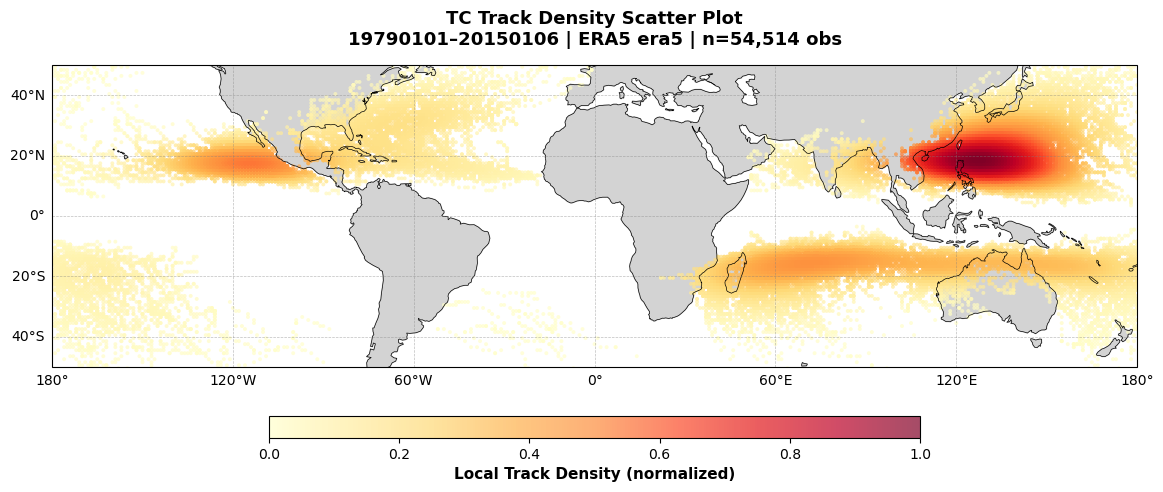

✓ Using data from memory (fast!)
Total TC observation points: 54,514
Time period: 433 months
Max transits/month: 0.83
Track density grid saved to: /work/users/mccorda/tc_analysis/Figures/track_density_grid_ERA5_era5_19790101_20150106.pdf


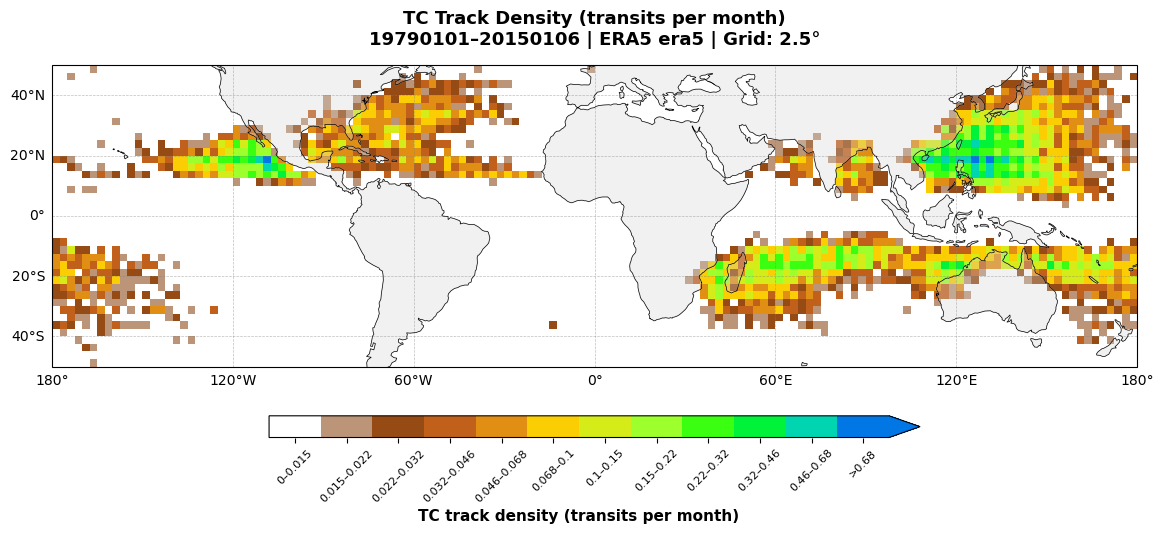

✓ Using data from memory (fast!)

Points per category:
  Cat 0: 5,184 points
  Cat 1: 33,760 points
  Cat 2: 11,777 points
  Cat 3: 3,281 points
  Cat 4: 489 points
  Cat 5: 23 points
✓ 6-panel plot saved: /work/users/mccorda/tc_analysis/Figures/density_scatter_by_category_ERA5_era5_19790101_20150106.pdf


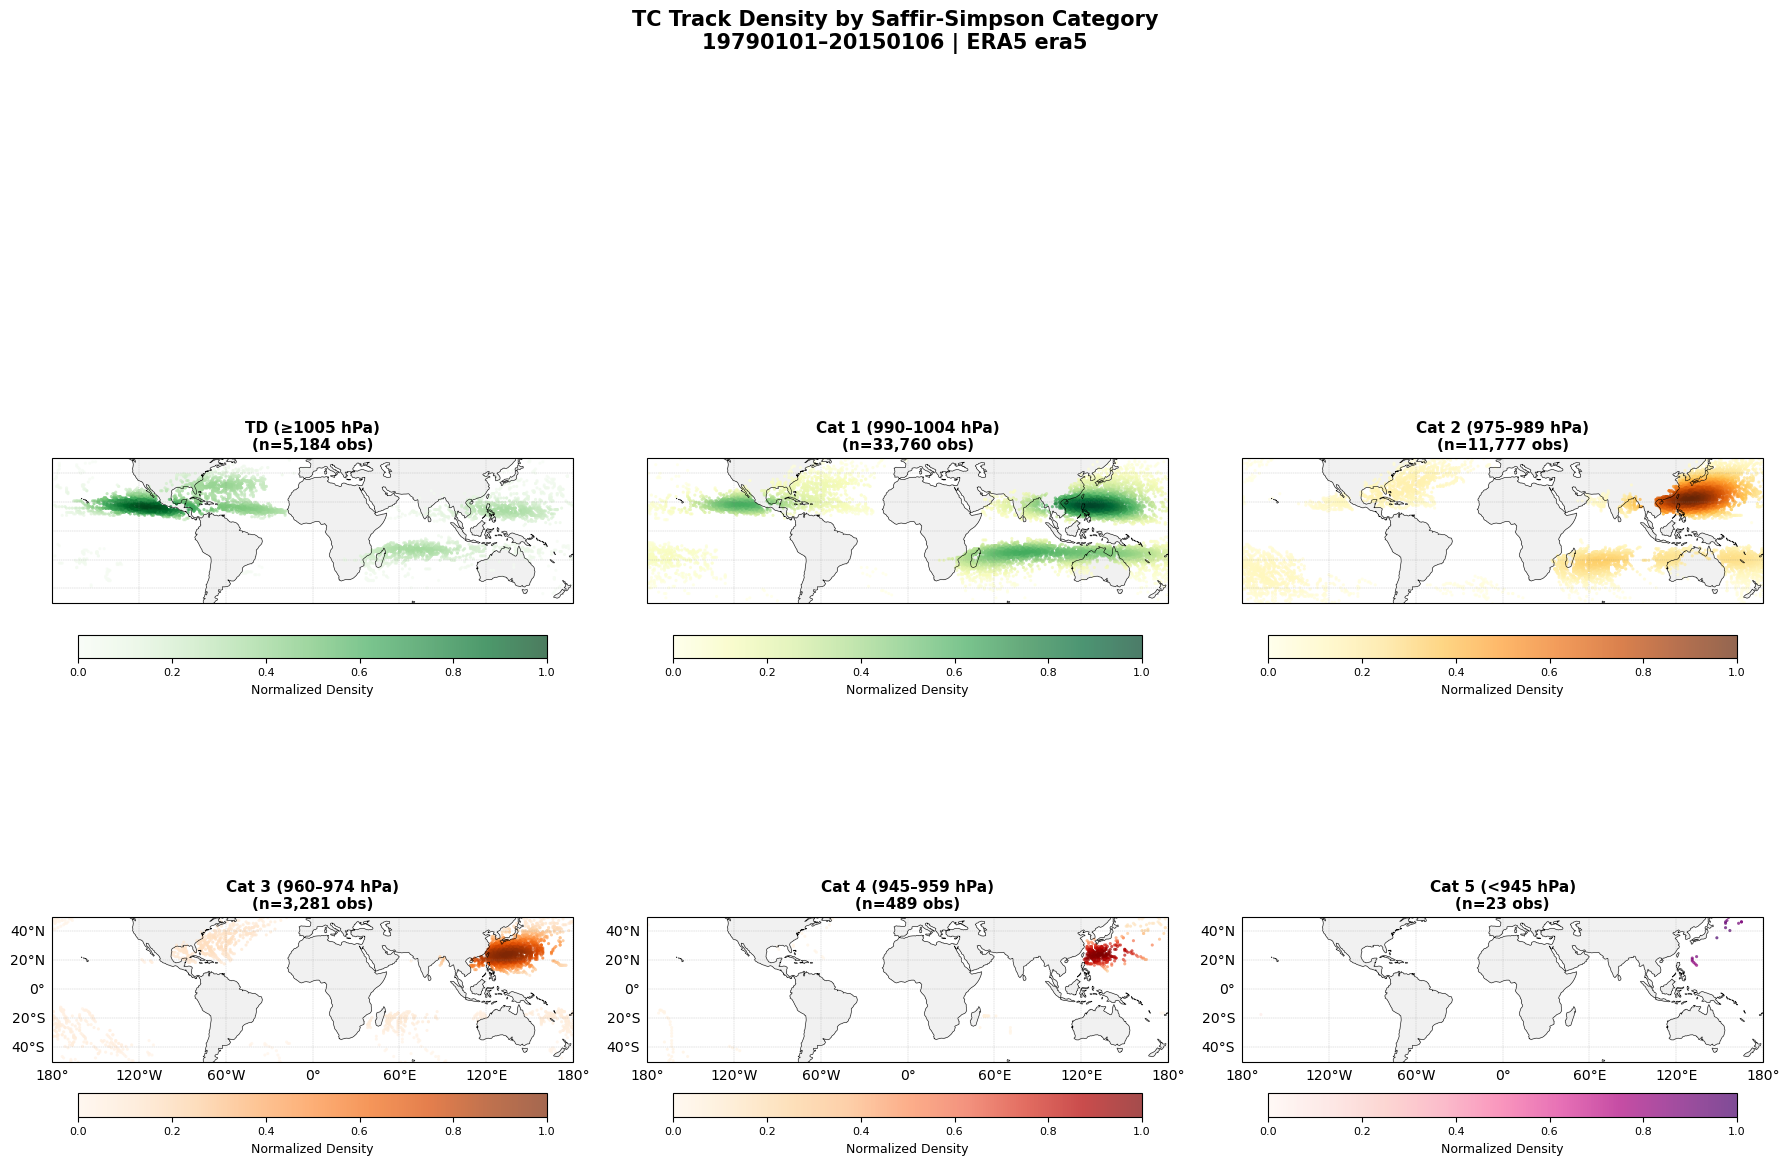

In [9]:
# ===========================================
# 6: plots using tc_data in memory
# ===========================================
plot_trajectories_direct(tc_data, config)  
plot_trajectories_colored(tc_data, config, color_by='category')  
plot_trajectories_by_category(tc_data, config, category=4)
plot_density_scatter(tc_data, config)  
plot_track_density_grid(tc_data, config, grid_size=2.5)  
plot_density_scatter_by_category(tc_data, config)  

Computing TC duration statistics from memory...

STATISTICHE DURATA CICLONI
Numero totale cicloni: 2349
Durata media: 5.6 giorni
Durata mediana: 4.8 giorni
Durata minima: 2.2 giorni (54 ore)
Durata massima: 20.8 giorni
Deviazione standard: 2.8 giorni


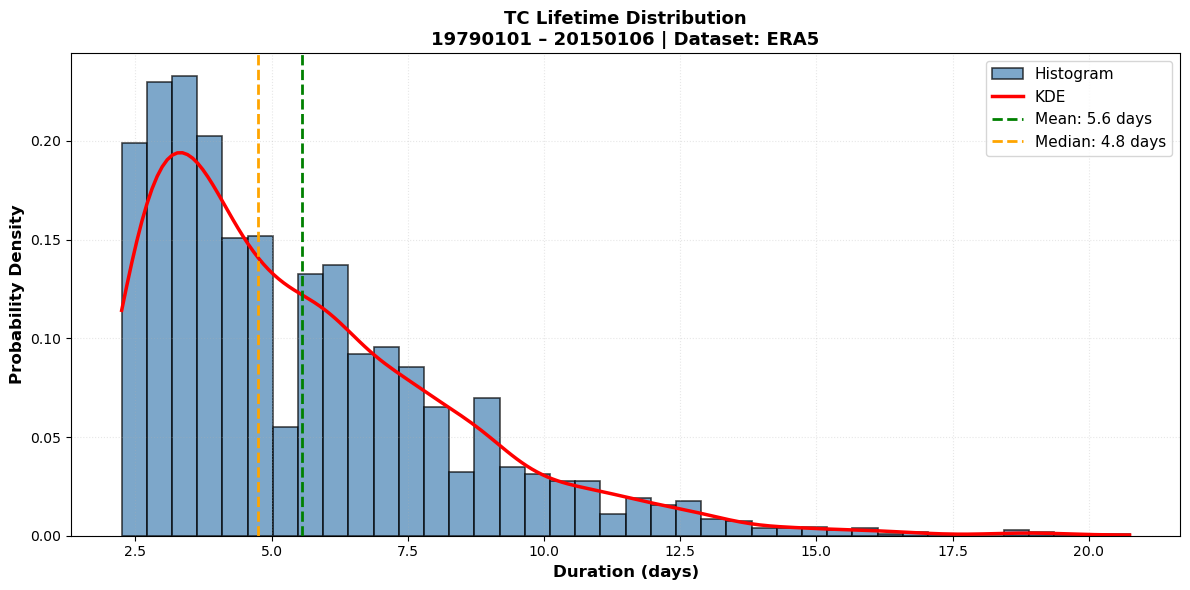

✓ Duration analysis complete (from memory)!


In [10]:
# ===========================================
# ANALISI DURATA TC - MEMORY-OPTIMIZED
# ===========================================
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import gaussian_kde
from plotting_TCs_custom_memory import category_from_slp_pa

print("Computing TC duration statistics from memory...")

# Usa dati in memoria (velocissimo!)
trajectories = tc_data.get_trajectories()

# Calcola durata per ogni ciclone
storm_durations = {}
durations_days = []
durations_by_cat = {cat: [] for cat in range(6)}
duration_vs_intensity = {'duration': [], 'min_slp': [], 'max_cat': []}

for storm_id, storm_data in trajectories.items():
    # Estrai info temporali
    years = storm_data['year']
    months = storm_data['month']
    days = storm_data['day']
    hours = storm_data['hour']
    slps = storm_data['slp'] / 100.0  # Pa → hPa
    
    # Crea datetime start e end
    try:
        start_dt = datetime(years[0], months[0], days[0], hours[0])
        end_dt = datetime(years[-1], months[-1], days[-1], hours[-1])
    except:
        continue
    
    # Calcola durata
    delta = end_dt - start_dt
    duration_days_val = delta.total_seconds() / (24 * 3600)
    
    # Categoria massima e min SLP
    min_slp = slps.min()
    max_cat = max([category_from_slp_pa(slp * 100) for slp in slps])
    
    # Salva
    durations_days.append(duration_days_val)
    durations_by_cat[max_cat].append(duration_days_val)
    
    duration_vs_intensity['duration'].append(duration_days_val)
    duration_vs_intensity['min_slp'].append(min_slp)
    duration_vs_intensity['max_cat'].append(max_cat)

durations_days = np.array(durations_days)

# Statistiche
print("\n" + "="*70)
print("STATISTICHE DURATA CICLONI")
print("="*70)
print(f"Numero totale cicloni: {len(durations_days)}")
print(f"Durata media: {durations_days.mean():.1f} giorni")
print(f"Durata mediana: {np.median(durations_days):.1f} giorni")
print(f"Durata minima: {durations_days.min():.1f} giorni ({durations_days.min()*24:.0f} ore)")
print(f"Durata massima: {durations_days.max():.1f} giorni")
print(f"Deviazione standard: {durations_days.std():.1f} giorni")

# ===========================================
# PLOT: Distribuzione durate (istogramma + KDE)
# ===========================================
fig, ax = plt.subplots(figsize=(12, 6))

# Istogramma
n, bins, patches = ax.hist(durations_days, bins=40, 
                           color='steelblue', alpha=0.7, 
                           edgecolor='black', linewidth=1.2,
                           density=True, label='Histogram')

# KDE
kde = gaussian_kde(durations_days)
x_range = np.linspace(durations_days.min(), durations_days.max(), 200)
ax.plot(x_range, kde(x_range), 'r-', linewidth=2.5, label='KDE')

# Linee di riferimento
ax.axvline(durations_days.mean(), color='green', linestyle='--', 
          linewidth=2, label=f'Mean: {durations_days.mean():.1f} days')
ax.axvline(np.median(durations_days), color='orange', linestyle='--', 
          linewidth=2, label=f'Median: {np.median(durations_days):.1f} days')

startdate = config['time']['startdate']
enddate = config['time']['enddate']
plotdir = config['paths']['plotdir']

ax.set_xlabel('Duration (days)', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability Density', fontsize=12, fontweight='bold')
ax.set_title(f'TC Lifetime Distribution\n'
             f'{startdate} – {enddate} | Dataset: {config["dataset"]["model"]}',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3, linestyle=':')

plt.tight_layout()
plt.savefig(os.path.join(plotdir,
            f'tc_duration_distribution_{config["dataset"]["model"]}_{config["dataset"]["exp"]}_{startdate}_{enddate}.pdf'),
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ Duration analysis complete (from memory)!")

Computing basin frequencies from memory...
Periodo analizzato: 1979-2014 (35 anni)

Frequenze annuali (storms/year):
  NH total: 40.4
  SH total: 23.3
    North Atlantic: 8.6
    East Pacific: 7.9
    West Pacific: 21.6
    North Indian: 2.3
    South Indian: 14.0
    South Pacific: 9.3


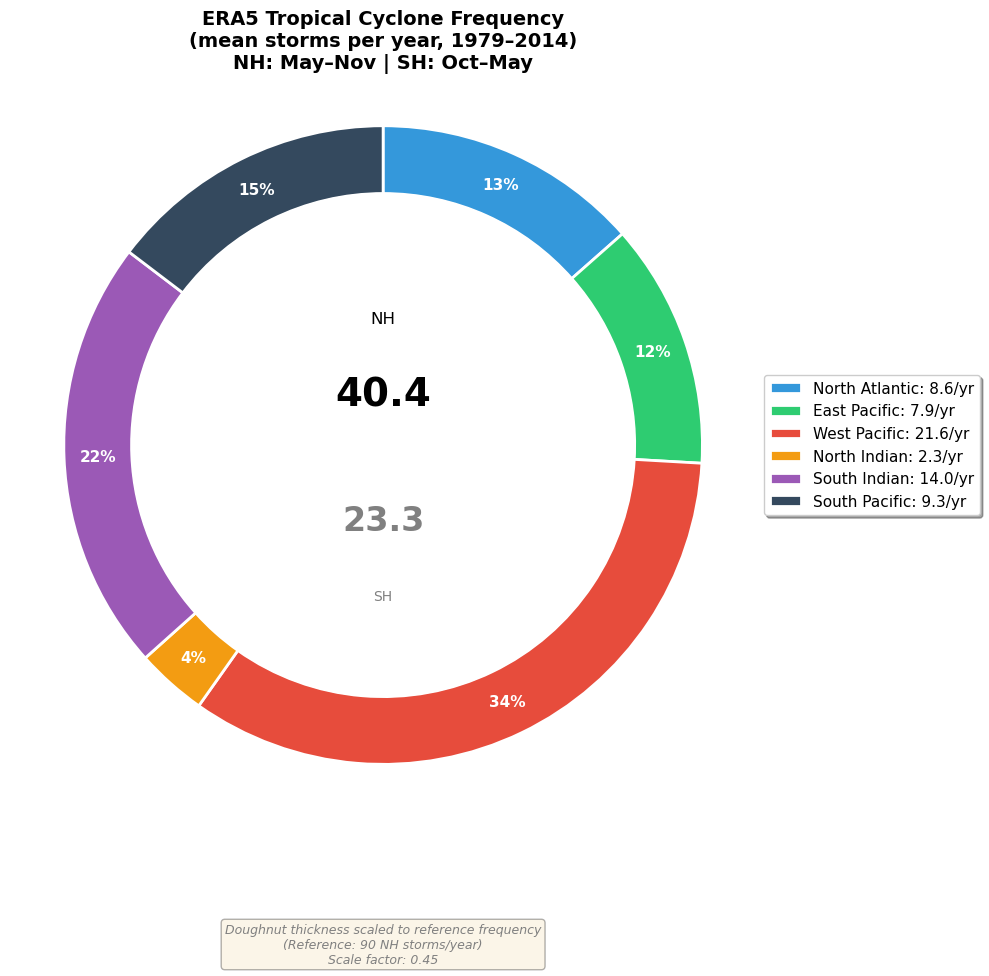


CONFRONTO CON ROBERTS ET AL. (2020) - ERA5
Bacino               Questo studio      Roberts et al.     Differenza     
----------------------------------------------------------------------
North Atlantic                    8.6             12.5     -3.9 (-31%)
East Pacific                      7.9             16.0     -8.1 (-51%)
West Pacific                     21.6             25.0     -3.4 (-14%)
North Indian                      2.3              5.5     -3.2 (-58%)
South Indian                     14.0             10.0      4.0 (+40%)
South Pacific                     9.3              4.5      4.8 (+108%)
----------------------------------------------------------------------
NH Total                         40.4             59.0    -18.6 (-32%)
SH Total                         23.3             14.5      8.8 (+61%)


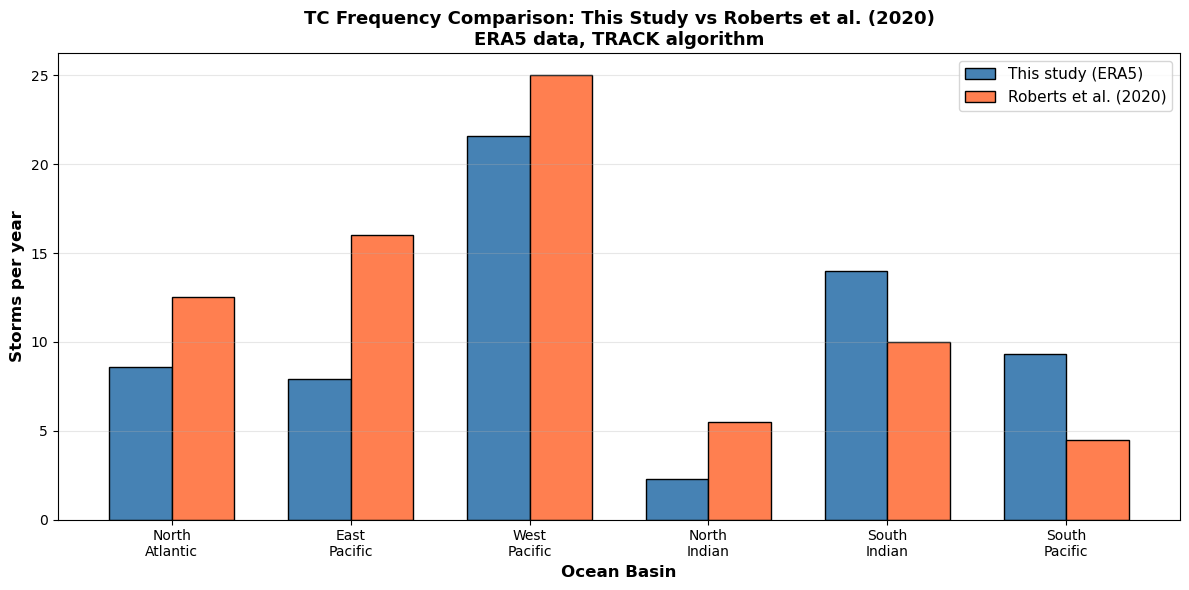

✓ Basin analysis complete (from memory)!


In [11]:
# ===========================================
# DOUGHNUT CHART - MEMORY-OPTIMIZED
# ===========================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from plotting_TCs_custom_memory import get_basin_ibtracs

print("Computing basin frequencies from memory...")

# Definisci stagioni cicloniche
nh_season_months = [5, 6, 7, 8, 9, 10, 11]  # May-November
sh_season_months = [10, 11, 12, 1, 2, 3, 4, 5]  # October-May

# Bacini
nh_basins = ['North Atlantic', 'East Pacific', 'West Pacific', 'North Indian']
sh_basins = ['South Indian', 'South Pacific']

# Usa dati in memoria (velocissimo!)
trajectories = tc_data.get_trajectories()
data_dict = tc_data.get_all_data()

# Conta storms unici per bacino (primo timestep)
basin_counts = {basin: set() for basin in nh_basins + sh_basins}
years_tracked = set()

for storm_id, storm_data in trajectories.items():
    # Primo timestep
    year = storm_data['year'][0]
    month = storm_data['month'][0]
    lon = storm_data['lon'][0]
    lat = storm_data['lat'][0]
    
    years_tracked.add(year)
    
    # Classifica bacino
    basin = get_basin_ibtracs(lon, lat)
    hemisphere = 'NH' if lat >= 0 else 'SH'
    
    # Filtra per stagione ciclonica
    is_nh_season = month in nh_season_months
    is_sh_season = month in sh_season_months
    
    if hemisphere == 'NH' and is_nh_season and basin in nh_basins:
        basin_counts[basin].add(storm_id)
    elif hemisphere == 'SH' and is_sh_season and basin in sh_basins:
        basin_counts[basin].add(storm_id)

# Calcola frequenze annuali
n_years = len(years_tracked)
print(f"Periodo analizzato: {min(years_tracked)}-{max(years_tracked)} ({n_years} anni)")

basin_freq = {basin: len(storms) / n_years for basin, storms in basin_counts.items()}

# Totali emisfero
nh_total = sum([basin_freq[b] for b in nh_basins])
sh_total = sum([basin_freq[b] for b in sh_basins])

print(f"\nFrequenze annuali (storms/year):")
print(f"  NH total: {nh_total:.1f}")
print(f"  SH total: {sh_total:.1f}")
for basin in nh_basins + sh_basins:
    print(f"    {basin}: {basin_freq[basin]:.1f}")

# ===========================================
# CREA DOUGHNUT CHART
# ===========================================
fig, ax = plt.subplots(figsize=(10, 10))

colors = {
    'North Atlantic': '#3498db',
    'East Pacific': '#2ecc71',
    'West Pacific': '#e74c3c',
    'North Indian': '#f39c12',
    'South Indian': '#9b59b6',
    'South Pacific': '#34495e'
}

basins_ordered = ['North Atlantic', 'East Pacific', 'West Pacific', 
                  'North Indian', 'South Indian', 'South Pacific']

sizes = [basin_freq[b] for b in basins_ordered]
colors_list = [colors[b] for b in basins_ordered]

# Riferimento e scala
reference_freq = 90.0  # storms/year NH (letteratura)
scale_factor = nh_total / reference_freq

inner_radius = 0.5
outer_radius = 0.5 + (0.3 * scale_factor)

# Percentuali globali
global_total = sum(sizes)
basin_percentages = [100.0 * basin_freq[b] / global_total for b in basins_ordered]

# Crea doughnut
wedges, texts = ax.pie(sizes, 
                       colors=colors_list,
                       startangle=90,
                       counterclock=False,
                       radius=outer_radius,
                       wedgeprops=dict(width=outer_radius-inner_radius, 
                                      edgecolor='white', 
                                      linewidth=2))

# Aggiungi percentuali
for wedge, pct in zip(wedges, basin_percentages):
    if pct < 3.0:
        continue
    
    angle = 0.5 * (wedge.theta1 + wedge.theta2)
    angle_rad = np.deg2rad(angle)
    r_text = inner_radius + 0.5 * (outer_radius - inner_radius)
    x = r_text * np.cos(angle_rad)
    y = r_text * np.sin(angle_rad)
    
    ax.text(x, y, f'{pct:.0f}%',
            ha='center', va='center',
            fontsize=11, fontweight='bold',
            color='white', zorder=12)

# Cerchio interno
circle = Circle((0, 0), inner_radius, color='white', zorder=10)
ax.add_artist(circle)

# Testo centrale
ax.text(0, 0.1, f'{nh_total:.1f}', 
       ha='center', va='center', fontsize=28, fontweight='bold',
       color='black', zorder=11)
ax.text(0, -0.15, f'{sh_total:.1f}', 
       ha='center', va='center', fontsize=24, fontweight='bold',
       color='gray', zorder=11)
ax.text(0, 0.25, 'NH', ha='center', va='center', fontsize=12, color='black', zorder=11)
ax.text(0, -0.3, 'SH', ha='center', va='center', fontsize=10, color='gray', zorder=11)

# Titolo
ax.set_title(f'ERA5 Tropical Cyclone Frequency\n'
             f'(mean storms per year, {min(years_tracked)}–{max(years_tracked)})\n'
             f'NH: May–Nov | SH: Oct–May',
             fontsize=14, fontweight='bold', pad=20)

# Legenda
legend_labels = [f'{basin}: {basin_freq[basin]:.1f}/yr' for basin in basins_ordered]
ax.legend(wedges, legend_labels, 
         loc='center left', bbox_to_anchor=(1, 0, 0.5, 1),
         fontsize=11, frameon=True, fancybox=True, shadow=True)

# Note
note_text = (f"Doughnut thickness scaled to reference frequency\n"
             f"(Reference: {reference_freq:.0f} NH storms/year)\n"
             f"Scale factor: {scale_factor:.2f}")
ax.text(0, -0.95, note_text, 
       ha='center', va='top', fontsize=9, 
       style='italic', color='gray',
       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

ax.axis('equal')

startdate = config['time']['startdate']
enddate = config['time']['enddate']
plotdir = config['paths']['plotdir']

plt.tight_layout()
plt.savefig(os.path.join(plotdir,
            f'tc_doughnut_frequency_{config["dataset"]["model"]}_{config["dataset"]["exp"]}_{startdate}_{enddate}.pdf'),
            dpi=300, bbox_inches='tight')
plt.show()

# ===========================================
# CONFRONTO CON ROBERTS ET AL. (2020)
# ===========================================
roberts_era5 = {
    'North Atlantic': 12.5, 'East Pacific': 16.0, 'West Pacific': 25.0,
    'North Indian': 5.5, 'South Indian': 10.0, 'South Pacific': 4.5,
    'NH_total': 59.0, 'SH_total': 14.5
}

print("\n" + "="*70)
print("CONFRONTO CON ROBERTS ET AL. (2020) - ERA5")
print("="*70)
print(f"{'Bacino':<20} {'Questo studio':<18} {'Roberts et al.':<18} {'Differenza':<15}")
print("-"*70)

for basin in basins_ordered:
    our_val = basin_freq[basin]
    roberts_val = roberts_era5.get(basin, np.nan)
    diff = our_val - roberts_val
    diff_pct = (diff / roberts_val * 100) if roberts_val > 0 else 0
    print(f"{basin:<20} {our_val:>16.1f} {roberts_val:>16.1f} {diff:>8.1f} ({diff_pct:+.0f}%)")

print("-"*70)
print(f"{'NH Total':<20} {nh_total:>16.1f} {roberts_era5['NH_total']:>16.1f} "
      f"{nh_total - roberts_era5['NH_total']:>8.1f} "
      f"({(nh_total - roberts_era5['NH_total'])/roberts_era5['NH_total']*100:+.0f}%)")
print(f"{'SH Total':<20} {sh_total:>16.1f} {roberts_era5['SH_total']:>16.1f} "
      f"{sh_total - roberts_era5['SH_total']:>8.1f} "
      f"({(sh_total - roberts_era5['SH_total'])/roberts_era5['SH_total']*100:+.0f}%)")

# Bar chart comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(basins_ordered))
width = 0.35

bars1 = ax.bar(x - width/2, [basin_freq[b] for b in basins_ordered], width,
              label='This study (ERA5)', color='steelblue', edgecolor='black')
bars2 = ax.bar(x + width/2, [roberts_era5[b] for b in basins_ordered], width,
              label='Roberts et al. (2020)', color='coral', edgecolor='black')

ax.set_xlabel('Ocean Basin', fontsize=12, fontweight='bold')
ax.set_ylabel('Storms per year', fontsize=12, fontweight='bold')
ax.set_title(f'TC Frequency Comparison: This Study vs Roberts et al. (2020)\n'
             f'ERA5 data, TRACK algorithm',
             fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([b.replace(' ', '\n') for b in basins_ordered], fontsize=10)
ax.legend(fontsize=11)
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(plotdir,
            f'tc_frequency_comparison_{config["dataset"]["model"]}_{config["dataset"]["exp"]}_{startdate}_{enddate}.pdf'),
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ Basin analysis complete (from memory)!")

In [12]:
client.shutdown()
cluster.close()